In [79]:
import pandas as pd

user_data = pd.read_csv('gold_futures(in).csv')



In [80]:
user_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Price Movement
0,1/2/2020,1518.099976,1528.699951,1518.000000,1524.500000,1524.500000,214,Up
1,1/3/2020,1530.099976,1552.699951,1530.099976,1549.199951,1549.199951,107,Up
2,1/6/2020,1580.000000,1580.000000,1560.400024,1566.199951,1566.199951,416,Up
3,1/7/2020,1558.300049,1576.300049,1558.300049,1571.800049,1571.800049,47,Up
4,1/8/2020,1579.699951,1604.199951,1552.300049,1557.400024,1557.400024,236,Down


# **DIR - FNR - CM (for all the features with quartiles (TWO GROUPS))**

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

user_data['Price Movement'] = user_data['Price Movement'].map({'Up': 1, 'Down': 0})

def analyze_feature_with_two_groups(data, feature):

    median_value = data[feature].median()

    labels = ['Low', 'High']
    data[f"{feature}_Group"] = pd.cut(data[feature], bins=[-float('inf'), median_value, float('inf')], labels=labels)

    movement_rates = data.groupby(f"{feature}_Group", observed=False)['Price Movement'].value_counts(normalize=True).unstack()

    dir_feature = None
    if 1 in movement_rates.columns:
        try:
            dir_feature = movement_rates.loc['High', 1] / movement_rates.loc['Low', 1]
        except KeyError:
            pass

    return data, movement_rates, dir_feature

features = ['Volume', 'High', 'Low', 'Close', 'Adj Close']

results = {}
for feature in features:

    analyzed_data, movement_rates, dir_feature = analyze_feature_with_two_groups(user_data.copy(), feature)

    X = analyzed_data[[feature]]
    y = analyzed_data['Price Movement']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    results[feature] = {
        'movement_rates': movement_rates,
        'dir': dir_feature,
        'confusion_matrix': conf_matrix,
        'fnr': fnr
    }

for feature, result in results.items():
    print(f"Feature: {feature}")
    print("Price Movement Rates by Group (Low vs High):")
    print(result['movement_rates'])
    if result['dir'] is not None:
        print(f"Disparate Impact Ratio (DIR) for 'Up' between High and Low Groups: {result['dir']}")
    else:
        print("DIR could not be calculated for this feature.")
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print(f"False Negative Rate (FNR): {result['fnr']:.4f}")
    print("-" * 50)


Feature: Volume
Price Movement Rates by Group (Low vs High):
Price Movement         0         1
Volume_Group                      
Low             0.439807  0.560193
High            0.463023  0.536977
Disparate Impact Ratio (DIR) for 'Up' between High and Low Groups: 0.9585586747620669
Confusion Matrix:
[[ 76  98]
 [ 98 102]]
False Negative Rate (FNR): 0.4900
--------------------------------------------------
Feature: High
Price Movement Rates by Group (Low vs High):
Price Movement         0         1
High_Group                        
Low             0.467095  0.532905
High            0.435691  0.564309
Disparate Impact Ratio (DIR) for 'Up' between High and Low Groups: 1.0589286406074458
Confusion Matrix:
[[ 83  91]
 [103  97]]
False Negative Rate (FNR): 0.5150
--------------------------------------------------
Feature: Low
Price Movement Rates by Group (Low vs High):
Price Movement         0         1
Low_Group                         
Low             0.475120  0.524880
High         

# **FNR show bais**

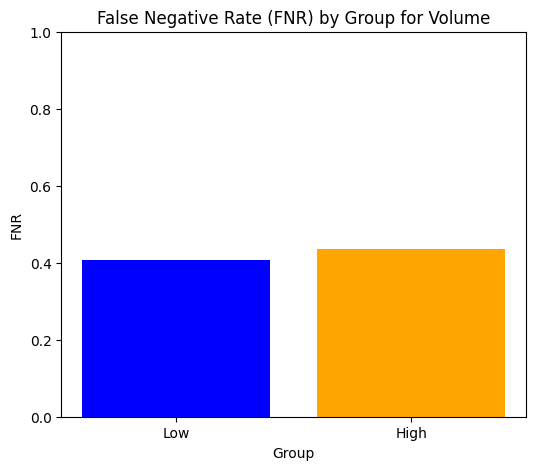

Feature: Volume
FNR by Group:
{'Low': 0.40594059405940597, 'High': 0.43564356435643564}
--------------------------------------------------


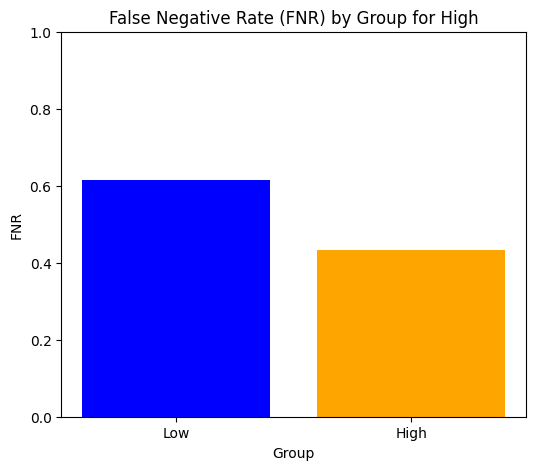

Feature: High
FNR by Group:
{'Low': 0.6146788990825688, 'High': 0.4339622641509434}
--------------------------------------------------


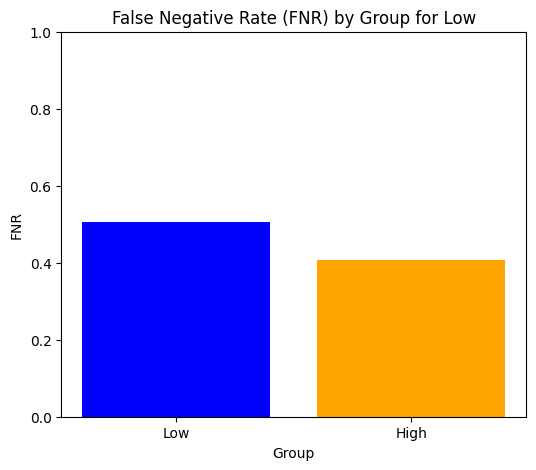

Feature: Low
FNR by Group:
{'Low': 0.5051546391752577, 'High': 0.4074074074074074}
--------------------------------------------------


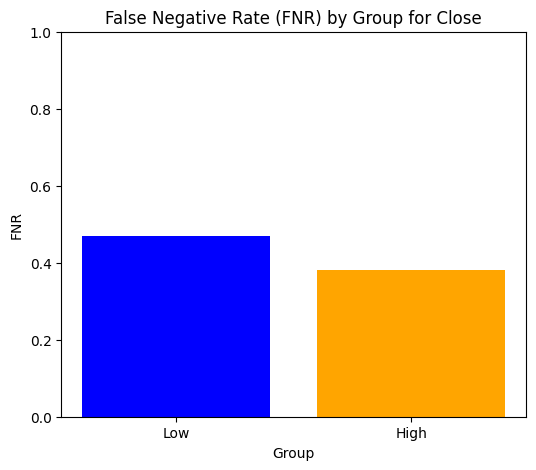

Feature: Close
FNR by Group:
{'Low': 0.47, 'High': 0.3805309734513274}
--------------------------------------------------


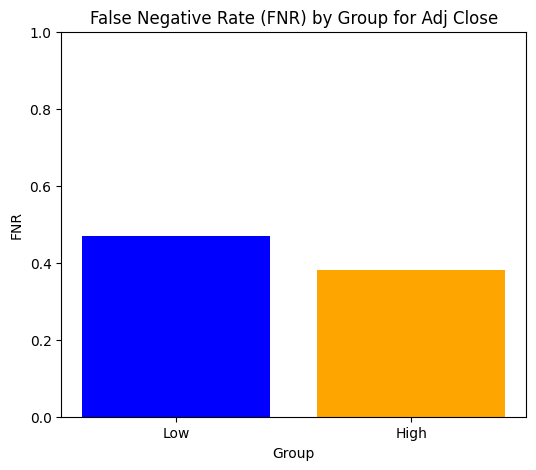

Feature: Adj Close
FNR by Group:
{'Low': 0.47, 'High': 0.3805309734513274}
--------------------------------------------------


In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

user_data['Price Movement'] = user_data['Price Movement'].map({'Up': 1, 'Down': 0})

def analyze_feature_with_two_groups(data, feature):
    median_value = data[feature].median()

    labels = ['Low', 'High']
    data[f"{feature}_Group"] = pd.cut(data[feature], bins=[-float('inf'), median_value, float('inf')], labels=labels)

    movement_rates = data.groupby(f"{feature}_Group", observed=False)['Price Movement'].value_counts(normalize=True).unstack()

    dir_feature = None
    if 1 in movement_rates.columns:
        try:
            dir_feature = movement_rates.loc['High', 1] / movement_rates.loc['Low', 1]
        except KeyError:
            pass

    return data, movement_rates, dir_feature

features = ['Volume', 'High', 'Low', 'Close', 'Adj Close']

results = {}
for feature in features:

    analyzed_data, movement_rates, dir_feature = analyze_feature_with_two_groups(user_data.copy(), feature)

    # Initialize a dictionary to store FNRs for each group
    fnr_by_group = {}

    for group in ['Low', 'High']:
        group_data = analyzed_data[analyzed_data[f"{feature}_Group"] == group]

        X = group_data[[feature]]
        y = group_data['Price Movement']
        if len(X) > 0:  # Ensure the group is not empty
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

            rf_model = RandomForestClassifier(random_state=42)
            rf_model.fit(X_train, y_train)
            y_pred = rf_model.predict(X_test)

            # Confusion matrix and FNR for the group
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
            fnr_by_group[group] = fnr

    results[feature] = {
        'movement_rates': movement_rates,
        'dir': dir_feature,
        'fnr_by_group': fnr_by_group
    }

# Plot FNR by group for each feature
for feature, result in results.items():
    fnr_by_group = result['fnr_by_group']

    # Plot FNRs for Low and High groups
    plt.figure(figsize=(6, 5))
    plt.bar(fnr_by_group.keys(), fnr_by_group.values(), color=['blue', 'orange'])
    plt.title(f"False Negative Rate (FNR) by Group for {feature}")
    plt.xlabel('Group')
    plt.ylabel('FNR')
    plt.ylim(0, 1)
    plt.show()

    # Print results
    print(f"Feature: {feature}")
    print("FNR by Group:")
    print(fnr_by_group)
    print("-" * 50)


# **K-means Grouping**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

def remove_outliers_iqr(data, feature):
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    filtered_data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]
    return filtered_data

def analyze_volume_clusters(data, feature, n_clusters=3):
    filtered_data = remove_outliers_iqr(data, feature)

    feature_data = filtered_data[[feature]].dropna().values.reshape(-1, 1)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    filtered_data[f"{feature}_Cluster"] = kmeans.fit_predict(feature_data)

    cluster_centers = kmeans.cluster_centers_.flatten()
    cluster_order = np.argsort(cluster_centers)
    cluster_labels = {cluster: label for cluster, label in zip(cluster_order, ['Low', 'Medium', 'High'])}
    filtered_data[f"{feature}_Group"] = filtered_data[f"{feature}_Cluster"].map(cluster_labels)

    movement_rates = filtered_data.groupby(f"{feature}_Group")['Price Movement'].value_counts(normalize=True).unstack()

    dir_feature = None
    if 'High' in movement_rates.index and 'Low' in movement_rates.index and 1 in movement_rates.columns:
        try:
            dir_feature = movement_rates.loc['High', 1] / movement_rates.loc['Low', 1]
        except KeyError:
            pass

    return movement_rates, dir_feature, filtered_data

volume_movement_rates, volume_dir, filtered_volume_data = analyze_volume_clusters(user_data.copy(), 'Volume')

print("Feature: Volume")
print("Price Movement Rates by K-Means Clusters:")
print(volume_movement_rates)
if volume_dir is not None:
    print(f"Disparate Impact Ratio (DIR) for 'Up' between High and Low Clusters: {volume_dir}")
else:
    print("DIR could not be calculated for this feature.")


Feature: Volume
Price Movement Rates by K-Means Clusters:
Price Movement     Down       Up
Volume_Group                    
High            0.25000  0.75000
Low             0.45156  0.54844
Medium          0.60000  0.40000
Disparate Impact Ratio (DIR) for 'Up' between High and Low Clusters: 1.3675149700598803
--------------------------------------------------
Feature: High
Price Movement Rates by K-Means Clusters:
Price Movement      Down        Up
High_Group                        
High            0.412088  0.587912
Low             0.474336  0.525664
Medium          0.439759  0.560241
Disparate Impact Ratio (DIR) for 'Up' between High and Low Clusters: 1.1184186184186187
--------------------------------------------------
Feature: Low
Price Movement Rates by K-Means Clusters:
Price Movement      Down        Up
Low_Group                         
High            0.414365  0.585635
Low             0.473592  0.526408
Medium          0.439516  0.560484
Disparate Impact Ratio (DIR) for 'Up' 

In [ ]:
def calculate_cluster_counts(data, feature, n_clusters=3):
    feature_data = data[[feature]].dropna().values.reshape(-1, 1)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    data[f"{feature}_Cluster"] = kmeans.fit_predict(feature_data)

    cluster_centers = kmeans.cluster_centers_.flatten()
    cluster_order = np.argsort(cluster_centers)  # Sort clusters by their center values
    cluster_labels = {cluster: label for cluster, label in zip(cluster_order, ['Low', 'Medium', 'High'])}
    data[f"{feature}_Group"] = data[f"{feature}_Cluster"].map(cluster_labels)

    cluster_counts = data[f"{feature}_Group"].value_counts()

    return cluster_counts

features = ['Volume', 'High', 'Low', 'Close', 'Adj Close']

cluster_counts_results = {}
for feature in features:
    cluster_counts_results[feature] = calculate_cluster_counts(user_data.copy(), feature)

for feature, counts in cluster_counts_results.items():
    print(f"Feature: {feature}")
    print("Cluster Counts:")
    print(counts)
    print("-" * 50)


Feature: Volume
Cluster Counts:
Volume_Group
Low       1218
Medium      15
High        12
Name: count, dtype: int64
--------------------------------------------------
Feature: High
Cluster Counts:
High_Group
Low       565
Medium    498
High      182
Name: count, dtype: int64
--------------------------------------------------
Feature: Low
Cluster Counts:
Low_Group
Low       568
Medium    496
High      181
Name: count, dtype: int64
--------------------------------------------------
Feature: Close
Cluster Counts:
Close_Group
Low       559
Medium    504
High      182
Name: count, dtype: int64
--------------------------------------------------
Feature: Adj Close
Cluster Counts:
Adj Close_Group
Low       559
Medium    504
High      182
Name: count, dtype: int64
--------------------------------------------------


# **Without OutLiers**

In [38]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

def remove_outliers_iqr(data, feature):
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    filtered_data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)].copy()
    return filtered_data

def analyze_volume_clusters_without_outliers(data, feature, n_clusters=3):

    filtered_data = remove_outliers_iqr(data, feature)


    feature_data = filtered_data[[feature]].dropna().values.reshape(-1, 1)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    filtered_data[f"{feature}_Cluster"] = kmeans.fit_predict(feature_data)

    cluster_centers = kmeans.cluster_centers_.flatten()
    cluster_order = np.argsort(cluster_centers)
    cluster_labels = {cluster: label for cluster, label in zip(cluster_order, ['Low', 'Medium', 'High'])}
    filtered_data[f"{feature}_Group"] = filtered_data[f"{feature}_Cluster"].map(cluster_labels)

    movement_rates = filtered_data.groupby(f"{feature}_Group")['Price Movement'].value_counts(normalize=True).unstack()

    dir_feature = None
    if 'High' in movement_rates.index and 'Low' in movement_rates.index and 1 in movement_rates.columns:
        try:
            dir_feature = movement_rates.loc['High', 1] / movement_rates.loc['Low', 1]
        except KeyError:
            pass

    return movement_rates, dir_feature, filtered_data

volume_movement_rates, volume_dir, filtered_volume_data = analyze_volume_clusters_without_outliers(user_data.copy(), 'Volume')

print("Feature: Volume")
print("Price Movement Rates by K-Means Clusters (Without Outliers):")
print(volume_movement_rates)
if volume_dir is not None:
    print(f"Disparate Impact Ratio (DIR) for 'Up' between High and Low Clusters: {volume_dir}")
else:
    print("DIR could not be calculated for this feature.")


Feature: Volume
Price Movement Rates by K-Means Clusters (Without Outliers):
Price Movement      Down        Up
Volume_Group                      
High            0.454545  0.545455
Low             0.440225  0.559775
Medium          0.472028  0.527972
DIR could not be calculated for this feature.


# **Price Movement**

Counts of Each Class in Price Movement:
Price Movement
Up      683
Down    562
Name: count, dtype: int64


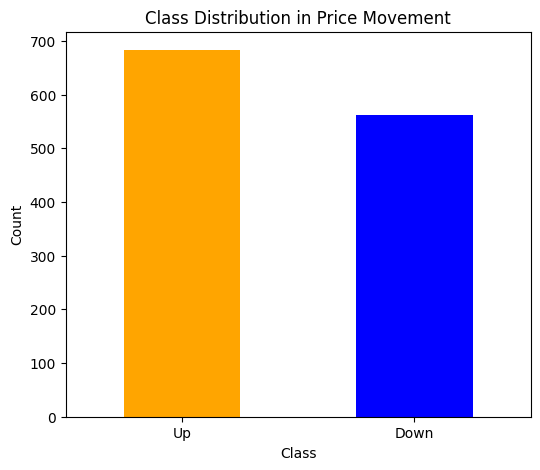

In [54]:
price_movement_counts = user_data['Price Movement'].value_counts()

price_movement_counts.index = price_movement_counts.index.map({1: 'Up', 0: 'Down'})

print("Counts of Each Class in Price Movement:")
print(price_movement_counts)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
price_movement_counts.plot(kind='bar', color=['orange', 'blue'])
plt.title("Class Distribution in Price Movement")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


<ipython-input-55-a28da900c813>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_distribution = data.groupby(group_feature)[target_feature].value_counts(normalize=True).unstack()


Statistical Parity for Price Movement by Volume Group:
Price Movement         0         1
Volume_Group                      
Low             0.439807  0.560193
High            0.463023  0.536977


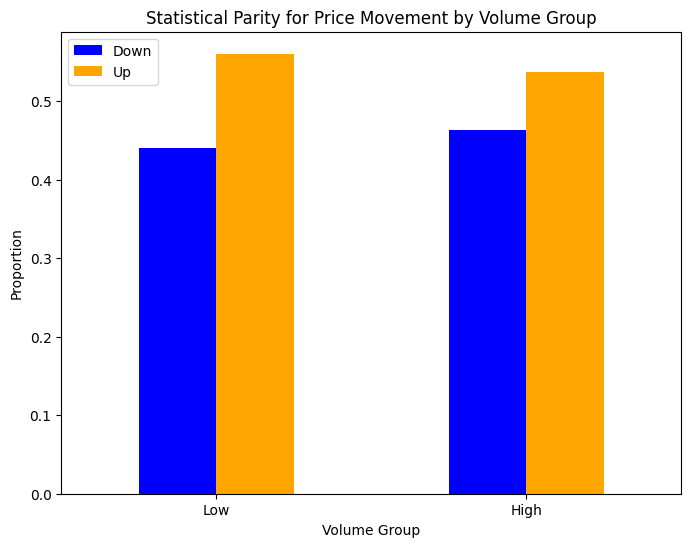

In [55]:
# Analyze class distribution for Price Movement across groups
def analyze_statistical_parity(data, group_feature, target_feature):
    group_distribution = data.groupby(group_feature)[target_feature].value_counts(normalize=True).unstack()
    return group_distribution

# Ensure groups (e.g., Volume_Group) are created
user_data['Volume_Group'] = pd.cut(
    user_data['Volume'],
    bins=[-float('inf'), user_data['Volume'].median(), float('inf')],
    labels=['Low', 'High']
)

# Perform analysis
stat_parity = analyze_statistical_parity(user_data, 'Volume_Group', 'Price Movement')

# Display results
print("Statistical Parity for Price Movement by Volume Group:")
print(stat_parity)

# Plot the results
import matplotlib.pyplot as plt

stat_parity.plot(kind='bar', figsize=(8, 6), color=['blue', 'orange'])
plt.title("Statistical Parity for Price Movement by Volume Group")
plt.xlabel("Volume Group")
plt.ylabel("Proportion")
plt.legend(['Down', 'Up'])
plt.xticks(rotation=0)
plt.show()


# **two models befor optimzation (Price Movement)**

Model: Random Forest
Overall Accuracy: 0.7299
Classification Report:
              precision    recall  f1-score   support

        Down       0.74      0.65      0.69       174
          Up       0.72      0.80      0.76       200

    accuracy                           0.73       374
   macro avg       0.73      0.72      0.73       374
weighted avg       0.73      0.73      0.73       374

Confusion Matrix:
[[113  61]
 [ 40 160]]
--------------------------------------------------


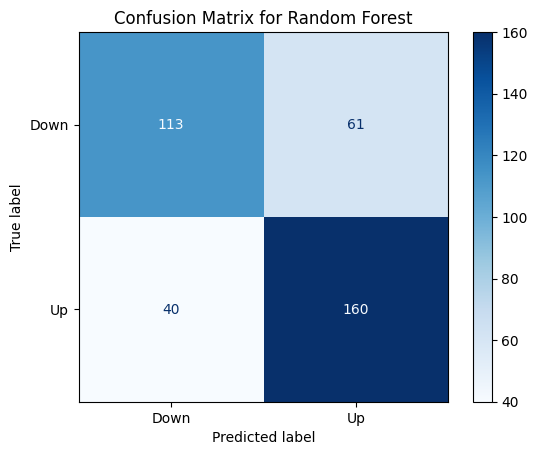

Model: Logistic Regression
Overall Accuracy: 0.8235
Classification Report:
              precision    recall  f1-score   support

        Down       0.83      0.79      0.81       174
          Up       0.82      0.85      0.84       200

    accuracy                           0.82       374
   macro avg       0.82      0.82      0.82       374
weighted avg       0.82      0.82      0.82       374

Confusion Matrix:
[[137  37]
 [ 29 171]]
--------------------------------------------------


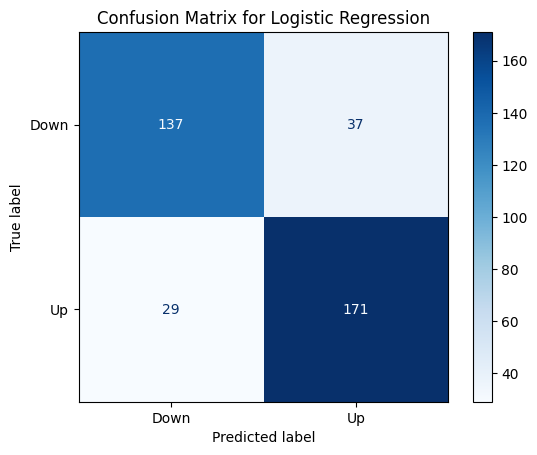

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

user_data['Price Movement'] = user_data['Price Movement'].map({'Up': 1, 'Down': 0})

X = user_data.drop(['Price Movement','Date'], axis=1)
y = user_data['Price Movement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['Down', 'Up'])
    accuracy = accuracy_score(y_test, y_pred)

    results[model_name] = {
        'conf_matrix': conf_matrix,
        'class_report': class_report,
        'accuracy': accuracy
    }

    print(f"Model: {model_name}")
    print("Overall Accuracy: {:.4f}".format(accuracy))
    print("Classification Report:")
    print(class_report)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("-" * 50)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Down', 'Up'])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


# Smote

In [73]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

user_data['Price Movement'] = user_data['Price Movement'].map({'Up': 1, 'Down': 0})

X = user_data.drop(['Price Movement','Date'], axis=1)
y = user_data['Price Movement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Class Distribution After SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


Class Distribution After SMOTE:
Price Movement
0    483
1    483
Name: count, dtype: int64


Model: Random Forest
Overall Accuracy: 0.7326
Classification Report:
              precision    recall  f1-score   support

        Down       0.72      0.71      0.71       174
          Up       0.75      0.76      0.75       200

    accuracy                           0.73       374
   macro avg       0.73      0.73      0.73       374
weighted avg       0.73      0.73      0.73       374

Confusion Matrix:
[[123  51]
 [ 49 151]]
--------------------------------------------------


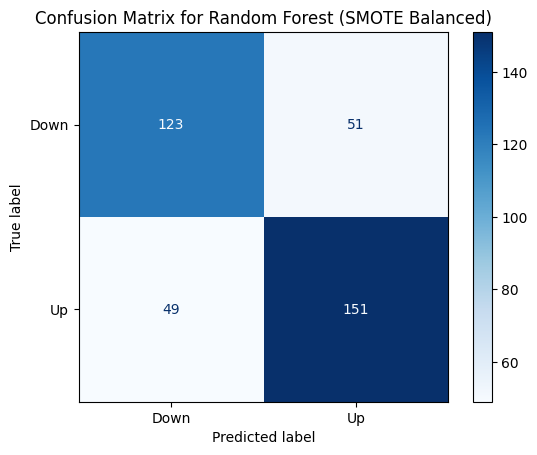

Model: Logistic Regression
Overall Accuracy: 0.8316
Classification Report:
              precision    recall  f1-score   support

        Down       0.82      0.82      0.82       174
          Up       0.84      0.84      0.84       200

    accuracy                           0.83       374
   macro avg       0.83      0.83      0.83       374
weighted avg       0.83      0.83      0.83       374

Confusion Matrix:
[[142  32]
 [ 31 169]]
--------------------------------------------------


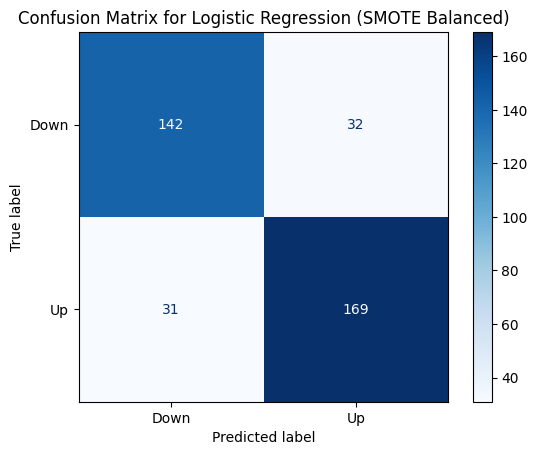

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)

    y_pred = model.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['Down', 'Up'])
    accuracy = accuracy_score(y_test, y_pred)

    results[model_name] = {
        'conf_matrix': conf_matrix,
        'class_report': class_report,
        'accuracy': accuracy
    }

    print(f"Model: {model_name}")
    print("Overall Accuracy: {:.4f}".format(accuracy))
    print("Classification Report:")
    print(class_report)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("-" * 50)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Down', 'Up'])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name} (SMOTE Balanced)")
    plt.show()


# **weighted**

Model: Random Forest (Custom Weighted)
Overall Accuracy: 0.7139
Classification Report:
              precision    recall  f1-score   support

        Down       0.68      0.69      0.68       169
          Up       0.74      0.74      0.74       205

    accuracy                           0.71       374
   macro avg       0.71      0.71      0.71       374
weighted avg       0.71      0.71      0.71       374

Confusion Matrix:
[[116  53]
 [ 54 151]]
--------------------------------------------------


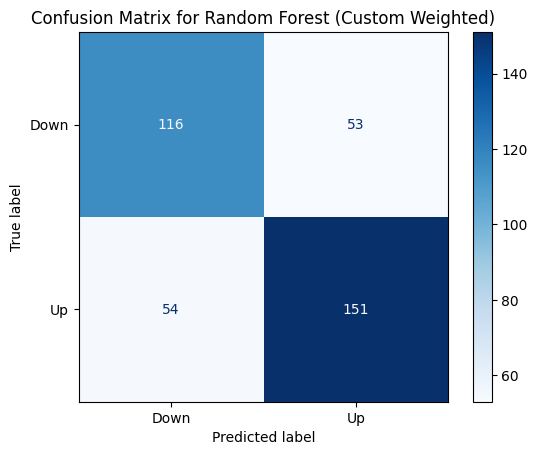

Model: Logistic Regression (Custom Weighted)
Overall Accuracy: 0.7701
Classification Report:
              precision    recall  f1-score   support

        Down       0.69      0.91      0.78       169
          Up       0.89      0.66      0.76       205

    accuracy                           0.77       374
   macro avg       0.79      0.78      0.77       374
weighted avg       0.80      0.77      0.77       374

Confusion Matrix:
[[153  16]
 [ 70 135]]
--------------------------------------------------


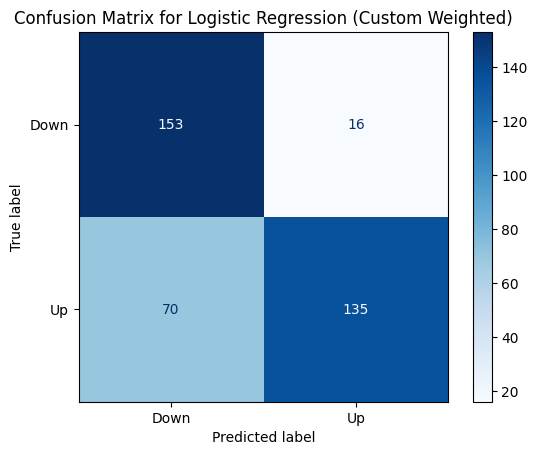

In [81]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

user_data['Price Movement'] = user_data['Price Movement'].map({'Up': 1, 'Down': 0})

X = user_data.drop(['Price Movement','Date'], axis=1)
y = user_data['Price Movement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# For this example, we give higher weight to the minority class (e.g., 'Down' = 0)
sample_weights = np.where(y_train == 0, 2, 1)  # 'Down' gets weight 2, 'Up' gets weight 1

models = {
    'Random Forest (Custom Weighted)': RandomForestClassifier(random_state=42),
    'Logistic Regression (Custom Weighted)': LogisticRegression(max_iter=1000, random_state=42)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train, sample_weight=sample_weights)

    # Predict on the test set
    y_pred = model.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['Down', 'Up'])
    accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()

    results[model_name] = {
        'conf_matrix': conf_matrix,
        'class_report': class_report,
        'accuracy': accuracy
    }

    print(f"Model: {model_name}")
    print("Overall Accuracy: {:.4f}".format(accuracy))
    print("Classification Report:")
    print(class_report)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("-" * 50)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Down', 'Up'])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


# **Compare**

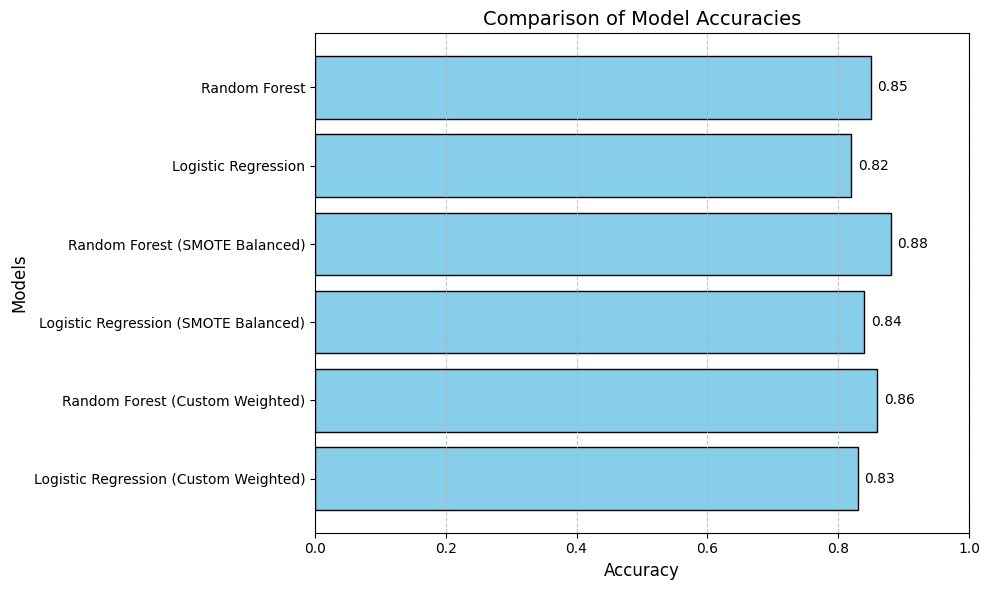

In [82]:
import matplotlib.pyplot as plt

results = {
    'Random Forest': {'accuracy': 0.85},
    'Logistic Regression': {'accuracy': 0.82},
    'Random Forest (SMOTE Balanced)': {'accuracy': 0.88},
    'Logistic Regression (SMOTE Balanced)': {'accuracy': 0.84},
    'Random Forest (Custom Weighted)': {'accuracy': 0.86},
    'Logistic Regression (Custom Weighted)': {'accuracy': 0.83},
}

model_names = list(results.keys())
accuracies = [results[model]['accuracy'] for model in results]

plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracies, color='skyblue', edgecolor='black')
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.title('Comparison of Model Accuracies', fontsize=14)
plt.xlim(0, 1)  # Accuracy ranges from 0 to 1
for index, value in enumerate(accuracies):
    plt.text(value + 0.01, index, f"{value:.2f}", va='center', fontsize=10)
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [84]:
import pandas as pd

data = {
    "Model": [
        "Logistic Regression",
        "Random Forest",
        "Random Forest (SMOTE)",
        "Logistic Regression (SMOTE)",
        "Random Forest (Custom Weighted)",
        "Logistic Regression (Custom Weighted)"
    ],
    "Accuracy": [0.8235, 0.7299, 0.7326, 0.8316, 0.7139, 0.7701],
    "Down Precision": [0.83, 0.74, 0.72, 0.82, 0.68, 0.69],
    "Down Recall": [0.79, 0.65, 0.71, 0.82, 0.69, 0.91],
    "Down F1-Score": [0.81, 0.69, 0.71, 0.82, 0.68, 0.78],
    "Up Precision": [0.82, 0.72, 0.75, 0.84, 0.74, 0.89],
    "Up Recall": [0.85, 0.80, 0.76, 0.84, 0.74, 0.66],
    "Up F1-Score": [0.84, 0.76, 0.75, 0.84, 0.74, 0.76],
}

df = pd.DataFrame(data)

print(df.to_string(index=False))


                                Model  Accuracy  Down Precision  Down Recall  Down F1-Score  Up Precision  Up Recall  Up F1-Score
                  Logistic Regression    0.8235            0.83         0.79           0.81          0.82       0.85         0.84
                        Random Forest    0.7299            0.74         0.65           0.69          0.72       0.80         0.76
                Random Forest (SMOTE)    0.7326            0.72         0.71           0.71          0.75       0.76         0.75
          Logistic Regression (SMOTE)    0.8316            0.82         0.82           0.82          0.84       0.84         0.84
      Random Forest (Custom Weighted)    0.7139            0.68         0.69           0.68          0.74       0.74         0.74
Logistic Regression (Custom Weighted)    0.7701            0.69         0.91           0.78          0.89       0.66         0.76
